# Example 1: A simple p-n junction

First, we import deltapv and necessary libraries. Notably, we use JAX's version of NumPy, which is purely functional and presents immutable arrays.

In [1]:
import deltapv as dpv
from jax import numpy as np, value_and_grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt

deltapv has a streamlined interface which allows defining a cell design with several lines of code. First, we must define the material that makes up the cell, which for the purpose of the example is a homojunction. The parameters have default values, so recombination parameters are not supplied here. Moreover, the units required are as follows:

eps : unitless

Chi , Eg , Et : eV

Nc , Nv , Ndop : cm^(-3)

mn , mp : cm^2 / V / s

tn , tp : s

A : cm^(-1) eV^(-1/2)

In [2]:
material = dpv.create_material(Chi=3.9,
                                Eg=1.5,
                                eps=9.4,
                                Nc=8e17,
                                Nv=1.8e19,
                                mn=100,
                                mp=100,
                                Et=0,
                                tn=1e-8,
                                tp=1e-8,
                                A=2e4)

We are ready to define the cell. The recombination velocities, in the format (Snl, Snr, Spl, Spr), are in units cm/s. We have equal donor and acceptor densities on either side of the pn junction, which has two layers of equal thickness 1e-4 cm. We simply use a uniform grid of 500 points for this example; where custom grids are required, the argument "grid" can be used to pass one.

In [3]:
des = dpv.make_design(n_points=500, Ls=[1e-4, 1e-4], mats=material, Ns=[1e17, -1e17], Snl=1e7, Snr=0, Spl=0, Spr=1e7)

While a PVDesign object contains all information about the cell, it does not contain light source information. In order to specify the light source, we must create a LightSource object with the incident_light() function. This defaults to returning the spectrum of one sun, but the spectrum can be specified with the kind ("sun", "white", "monochromatic", "user") and the wavelengths, Lambda, and corresponding power, P_in, respectively.

In [4]:
ls = dpv.incident_light()

Now we are ready to run the simulation, which solves for the equilibrium system, then the out-of-equilibrium case with illumination and bias up to the point when the current drops below zero.

In [5]:
results = dpv.simulate(des, ls)

INFO:deltapv:Solving equilibrium...
INFO:deltapv:	iteration: 1     |p|: 43.465213634039515        |F|: 8.286401972058485
INFO:deltapv:	iteration: 2     |p|: 37.702898650008436        |F|: 5.70497870827391
INFO:deltapv:	iteration: 3     |p|: 29.217509708062373        |F|: 4.514709328540997
INFO:deltapv:	iteration: 4     |p|: 19.475315587949318        |F|: 3.7112069608868556
INFO:deltapv:	iteration: 5     |p|: 12.798020158823388        |F|: 2.9322900878851663
INFO:deltapv:	iteration: 6     |p|: 13.364480352760294        |F|: 2.1976915973767044
INFO:deltapv:	iteration: 7     |p|: 11.647351454409208        |F|: 1.5489411252942984
INFO:deltapv:	iteration: 8     |p|: 8.93729416712193          |F|: 1.0617036690637167
INFO:deltapv:	iteration: 9     |p|: 6.170701063402813         |F|: 0.7646772016309449
INFO:deltapv:	iteration: 10    |p|: 3.7189005465566565        |F|: 0.4726757476335817
INFO:deltapv:	iteration: 11    |p|: 1.7178943318226578        |F|: 0.22887917507219566
INFO:deltapv:	iterati

The results returned are in the form of a dictionary with keys {"cell", "eq", "Voc", "mpp", "eff", "iv"}. "cell" refers to the initialized PVCell object which contains the generation density G from the optical model. "eq" and "Voc" are the solution potentials in the form of a named tuple for the equilibrium and Voc cases. "mpp" is the maximal power through the cell, and "iv" is a tuple of  voltages and currents describing the IV curve. deltapv provides several plotting functions, all of which can save the plot with keyword argument "filename".

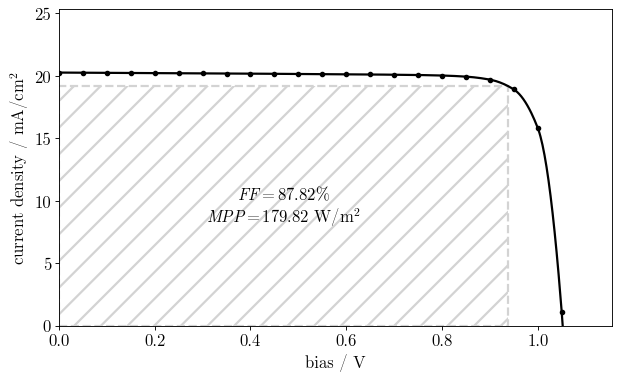

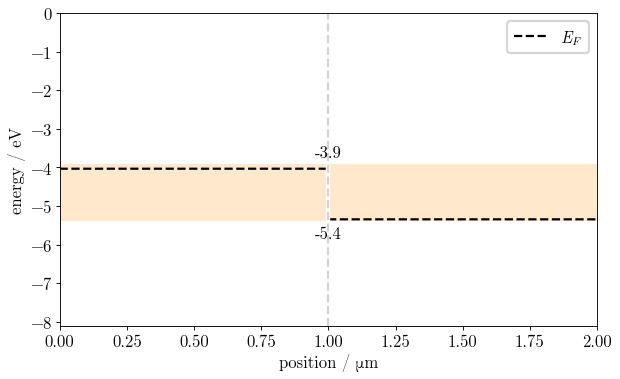

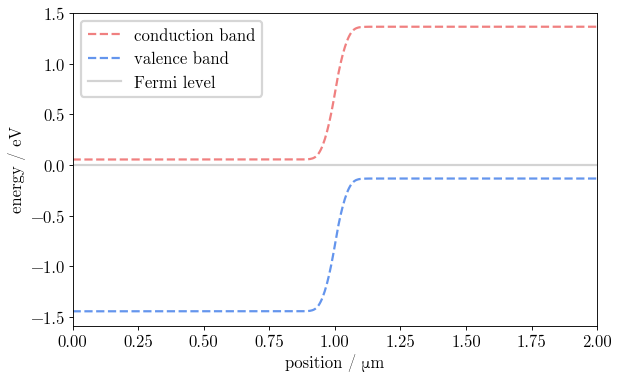

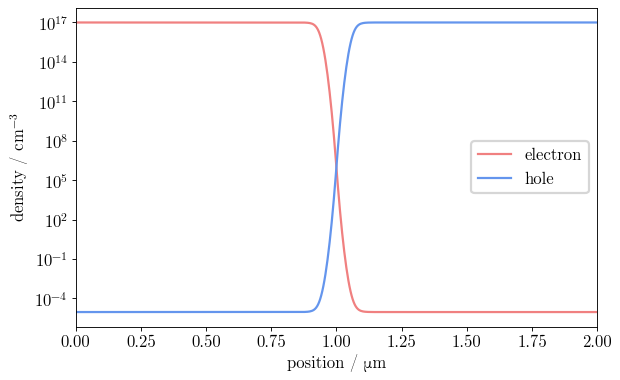

In [6]:
dpv.plot_iv_curve(*results["iv"])
dpv.plot_bars(des)
dpv.plot_band_diagram(des, results["eq"], eq=True)
dpv.plot_charge(des, results["eq"])

# Example 2: Optimizing a perovskite solar cell

First we define the fixed parameters below, together with the lower and upper bounds for all the optimized variables. The perovskite material is held fixed in this example, so we define it beforehand.

In [27]:
L_ETM = 5e-5
L_Perov = 1.1e-4
L_HTM = 5e-5
N = 500
A = 2e4
tau = 1e-6
S = 1e7
Eg_P = 1.5
Chi_P = 3.9
eps_P = 10
Nc_P = 3.9e18
Nv_P = 2.7e18
mn_P = 2
mp_P = 2
Br_P = 2.3e-9

Perov = deltapv.materials.create_material(Eg=Eg_P, Chi=Chi_P, eps=eps_P,
                                          Nc=Nc_P, Nv=Nv_P, mn=mn_P,
                                          mp=mp_P, tn=tau, tp=tau,
                                          Br=Br_P, A=A)

vl = np.array([1, 1, 1, 17, 17, 0, 0, 1, 1, 1, 17, 17, 0, 0, 17, 17], dtype=np.float64)
vu = np.array([5, 5, 20, 20, 20, 3, 3, 5, 5, 20, 20, 20, 3, 3, 20, 20], dtype=np.float64)

Next, we define a function to compute a quadratic exterior penalty for a candidate design. Aside from the box constraints, we also penalize for violating 5 generally nonlinear constraints.

In [29]:
def penalty(params, sigma=1e4):
    Eg_ETM = params[0]
    Chi_ETM = params[1]
    Nc_ETM = 10**params[3]
    Nv_ETM = 10**params[4]
    Eg_HTM = params[7]
    Chi_HTM = params[8]
    Nc_HTM = 10**params[10]
    Nv_HTM = 10**params[11]
    Nd_ETM = 10**params[14]
    Na_HTM = 10**params[15]

    PhiM0 = deltapv.physics.flatband_wf(Nc_ETM, Nv_ETM, Eg_ETM, Chi_ETM, Nd_ETM)
    PhiML = deltapv.physics.flatband_wf(Nc_HTM, Nv_HTM, Eg_HTM, Chi_HTM, -Na_HTM)

    g = np.array([Chi_ETM - PhiM0, Chi_HTM - Chi_P, PhiML - Chi_HTM - Eg_HTM,
                  Chi_HTM + Eg_HTM - Chi_P - Eg_P, Chi_P - Chi_ETM])
    
    upper = np.clip(params - vu, a_min=0)
    lower = np.clip(vl - params, a_min=0)
    cons = np.clip(g, a_min=0)
    pen = sigma * (np.sum(upper**2) + np.sum(lower**2) + np.sum(cons**2))

    return pen

Finally, we specify how to convert a parameter vector into a PVDesign, and the objective function f makes use of this to return the penalized negative efficiency given a parameter vector.

JAX's value_and_grad function is then used to differentiate f in an end-to-end manner, returning a function, df, which returns both the efficiency and its gradient with respect to the parameter vector.

In [30]:
def x2des(params, perov=Perov):

    Eg_ETM = params[0]
    Chi_ETM = params[1]
    eps_ETM = params[2]
    Nc_ETM = 10**params[3]
    Nv_ETM = 10**params[4]
    mn_ETM = 10**params[5]
    mp_ETM = 10**params[6]
    Eg_HTM = params[7]
    Chi_HTM = params[8]
    eps_HTM = params[9]
    Nc_HTM = 10**params[10]
    Nv_HTM = 10**params[11]
    mn_HTM = 10**params[12]
    mp_HTM = 10**params[13]
    Nd_ETM = 10**params[14]
    Na_HTM = 10**params[15]

    ETM = deltapv.materials.create_material(Eg=Eg_ETM,
                                            Chi=Chi_ETM,
                                            eps=eps_ETM,
                                            Nc=Nc_ETM,
                                            Nv=Nv_ETM,
                                            mn=mn_ETM,
                                            mp=mp_ETM,
                                            tn=tau,
                                            tp=tau,
                                            A=A)
    HTM = deltapv.materials.create_material(Eg=Eg_HTM,
                                            Chi=Chi_HTM,
                                            eps=eps_HTM,
                                            Nc=Nc_HTM,
                                            Nv=Nv_HTM,
                                            mn=mn_HTM,
                                            mp=mp_HTM,
                                            tn=tau,
                                            tp=tau,
                                            A=A)

    grid = np.linspace(0, L_ETM + L_Perov + L_HTM, N)
    des = deltapv.simulator.create_design(grid)

    region_ETM = lambda x: x <= L_ETM
    region_Perov = lambda x: np.logical_and(L_ETM < x, x <= L_ETM + L_Perov)
    region_HTM = lambda x: L_ETM + L_Perov < x

    des = deltapv.simulator.add_material(des, ETM, region_ETM)
    des = deltapv.simulator.add_material(des, perov, region_Perov)
    des = deltapv.simulator.add_material(des, HTM, region_HTM)
    des = deltapv.simulator.doping(des, Nd_ETM, region_ETM)
    des = deltapv.simulator.doping(des, -Na_HTM, region_HTM)
    des = deltapv.simulator.contacts(des, S, S, S, S)

    return des


def f(params):
    des = x2des(params)
    ls = deltapv.simulator.incident_light()
    results = deltapv.simulator.simulate(des, ls)
    eff = results["eff"] * 100
    pen = penalty(params)
    return -eff + pen


df = value_and_grad(f)

JAX provides a convenient Adam optimizer in its experimental.optimizers module. Here we write a wrapper function that keeps track of the growth of the objective, and returns the final parameter vector.

In [31]:
def adam(x0, niters, lr=1e-2, b1=0.1, b2=0.1):
    
    opt_init, opt_update, get_params = optimizers.adam(lr, b1=b1, b2=b2, eps=1e-8)
    opt_state = opt_init(x0)
    growth = []

    def take_step(step, opt_state):
        param = get_params(opt_state)
        value, grads = df(param)
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    for step in range(niters):
        value, opt_state = take_step(step, opt_state)
        growth.append(value)
    
    final = get_params(opt_state)
    growth = np.array(growth)

    return growth, final

We are now ready to begin the optimization process! For illustration purposes, we only do 10 gradient descent steps.

In [15]:
x0 = np.array([1.661788237392516, 4.698293002285373, 19.6342803183675, 18.83471869026531, 19.54569869328745, 0.7252792557586427, 1.6231392299175988, 2.5268524699070234, 2.51936429069554, 6.933634938056497, 19.41835918276137, 18.271793488422656, 0.46319949214386513, 0.2058139980642224, 18.63975340175838, 17.643726318153238])

growth, final = adam(x0, 10)

62921e-06     |F|: 6.839943857897255e-09    
INFO:deltapv:	iteration: 5     |p|: 1.0675309903949485e-10    |F|: 1.3145704026995161e-13   
INFO:deltapv:Solving for 0.6000000000000001 V (Step 12)...
INFO:deltapv:	iteration: 1     |p|: 0.152314225716682         |F|: 0.0007349503085453922    
INFO:deltapv:	iteration: 2     |p|: 0.018853443065762213      |F|: 3.321869842621004e-05    
INFO:deltapv:	iteration: 3     |p|: 0.010461524004921341      |F|: 4.695689498067291e-05    
INFO:deltapv:	iteration: 4     |p|: 7.07559583178608e-05      |F|: 1.3317674725769044e-07   
INFO:deltapv:	iteration: 5     |p|: 4.960414458799245e-09     |F|: 3.689400778037495e-12    
INFO:deltapv:Solving for 0.6500000000000001 V (Step 13)...
INFO:deltapv:	iteration: 1     |p|: 0.13034261011253315       |F|: 0.0023985636645537196    
INFO:deltapv:	iteration: 2     |p|: 0.011202023724529676      |F|: 7.334540482391487e-05    
INFO:deltapv:	iteration: 3     |p|: 0.007105950375622678      |F|: 0.00012333735252916125   


We compare the initial and final designs by plotting the energy levels. The efficiency is also seen to grow steadily over the 10 iterations from 6.5% to 9%.

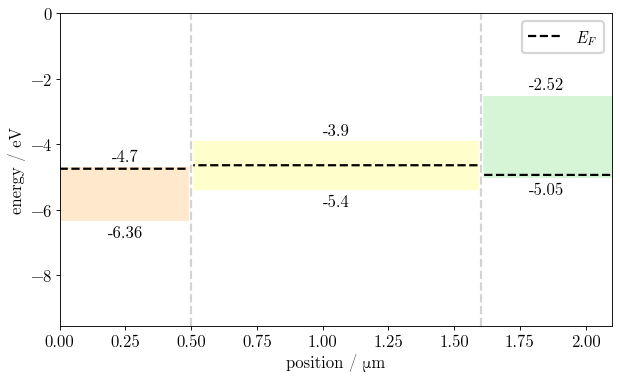

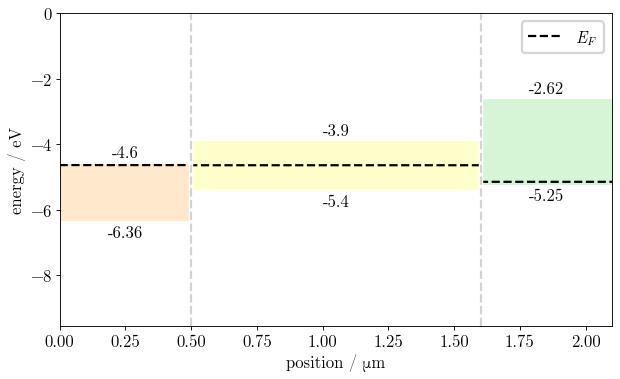

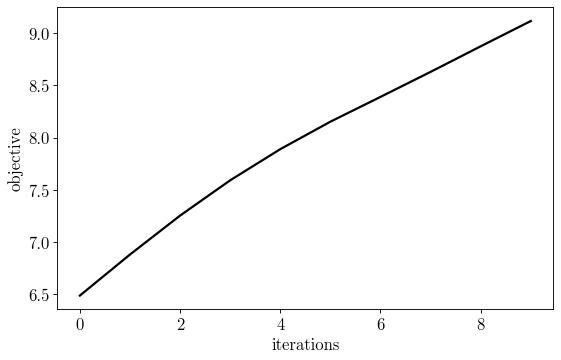

In [34]:
deltapv.plotting.plot_bars(x2des(x0))
deltapv.plotting.plot_bars(x2des(final))

plt.plot(-growth, color="black")
plt.xlabel("iterations")
plt.ylabel("objective")
plt.show()

# Example 3: Using empirical $IV$ curve for material discovery

Here, we extend the PSC optimization example by using gradient descent to "discover" the parameter $E_{g, P}$, which was fixed at 1.5eV before. Now suppose it is unknown, and we have a "target" $IV$ curve from empirical measurements, $J^*$. We use simulations to match the candidate and empirical $IV$ curves, specifically to minimize the quantity $\mathrm{RSS} = ||J - J^*||^2$. First, we define the residual function, r, that calculates the RSS given a guess for $E_{g, P}$, a parameter vector to specify the rest of the cell parameters, and a target, empirical $IV$ curve. The gradient, dr, can then be easily computed with AD.

In [53]:
def residual(Eg_P, params, target_j):
    perov = deltapv.materials.create_material(Eg=Eg_P,
                                              Chi=Chi_P,
                                              eps=eps_P,
                                              Nc=Nc_P,
                                              Nv=Nv_P,
                                              mn=mn_P,
                                              mp=mp_P,
                                              tn=tau,
                                              tp=tau,
                                              Br=Br_P,
                                              A=A)
    des = x2des(params, perov=perov)
    ls = deltapv.simulator.incident_light()
    results = deltapv.simulator.simulate(des, ls, n_steps=target_j.size)
    _, j = results["iv"]
    rss = np.sum((j - target_j)**2)
    return rss


dr = value_and_grad(residual, argnums=0)

Next we define a simple procedure for gradient descent with gradient clipping. The reason gradient clipping is helpful is that the residual grows much faster (in fact, resembling exponentially) as the candidate $E_{g, P}$ drops below the correct value, than when it is above it. This is attributed to the $IV$ curve somewhat "converging" as $E_{g, P}$ grows beyond a certain point, making the parameter difficult to identify. Clipping the gradients ensures the parameter does not change too rapidly, ameliorating convergence issues.

In [54]:
def gd_clip(x0, niters, params, target, lr=1, clip=0.1):
    rss = []
    xs = [x0]
    for i in range(niters):
        r, drdx = dr(x0, params, target)
        drdx = np.clip(drdx, -clip, clip)
        x0 -= lr * drdx
        rss.append(r)
        xs.append(x0)
    rss = np.array(rss)
    xs = np.array(xs)
    return xs, rss

We will also need an "empirical" $IV$ curve. In a realistic setting this would be from an experiment, but here we compute the $IV$ curve of the result of optimization in Example 2.

In [49]:
des = x2des(final)
ls = deltapv.simulator.incident_light()
results = deltapv.simulator.simulate(des, ls)
_, target = results["iv"]

INFO:deltapv:Solving equilibrium...
INFO:deltapv:	iteration: 1     |p|: 31.95979455420602         |F|: 6.04446764124971
INFO:deltapv:	iteration: 2     |p|: 18.123905580339503        |F|: 4.031157278498261
INFO:deltapv:	iteration: 3     |p|: 14.540269691709854        |F|: 1.5294190534407537
INFO:deltapv:	iteration: 4     |p|: 11.275399915981938        |F|: 1.0925126353654104
INFO:deltapv:	iteration: 5     |p|: 8.2598268890888           |F|: 0.8003375816151593
INFO:deltapv:	iteration: 6     |p|: 5.535422538856823         |F|: 0.5374681276531444
INFO:deltapv:	iteration: 7     |p|: 3.1695048164237254        |F|: 0.3098096209220555
INFO:deltapv:	iteration: 8     |p|: 1.2799678421661433        |F|: 0.12828477266016672
INFO:deltapv:	iteration: 9     |p|: 0.10544519328445394       |F|: 0.012693950388575785
INFO:deltapv:	iteration: 10    |p|: 0.00012945453760066305    |F|: 1.3134549917031366e-06
INFO:deltapv:	iteration: 11    |p|: 1.6447595425222803e-09    |F|: 2.6258118245419916e-11
INFO:delta

Now we are ready for optimization. As a demonstration, we perform 10 gradient steps.

In [50]:
xs, rss = gd_clip(1.03, 10, final, target)

048659802       |F|: 3.2346791546666826e-05   
INFO:deltapv:	iteration: 2     |p|: 0.0030470712076588204     |F|: 3.323624855407386e-07    
INFO:deltapv:	iteration: 3     |p|: 0.0016650001861833802     |F|: 4.82473946354857e-07     
INFO:deltapv:	iteration: 4     |p|: 6.482042795910614e-07     |F|: 7.485244627303827e-11    
INFO:deltapv:Solving for 0.6000000000000001 V (Step 12)...
INFO:deltapv:	iteration: 1     |p|: 0.10546494088963324       |F|: 0.0001757171696128695    
INFO:deltapv:	iteration: 2     |p|: 0.009127602037706515      |F|: 5.042771930571261e-06    
INFO:deltapv:	iteration: 3     |p|: 0.00505128602038755       |F|: 7.948363872891168e-06    
INFO:deltapv:	iteration: 4     |p|: 1.7645676847547178e-05    |F|: 1.0012521578310965e-08   
INFO:deltapv:	iteration: 5     |p|: 2.892645691411349e-10     |F|: 1.2463495055658562e-13   
INFO:deltapv:Solving for 0.6500000000000001 V (Step 13)...
INFO:deltapv:	iteration: 1     |p|: 0.15857177063433742       |F|: 0.0007540291704730935   

We plot the RSS and estimated material parameter over iterations. The RSS goes down rapidly, but it can be seen that the parameter estimate overshoots and goes back down to the true value of 1.5 much slower than it grows. The reason why a specific number like 1.03 was chosen as the initial guess instead of a whole number like 1.0 is to illustrate this issue: if we had started with 1.0, the algorithm would have taken 5 steps of +0.1 and arrived exactly at the true value (which is not very realistic).

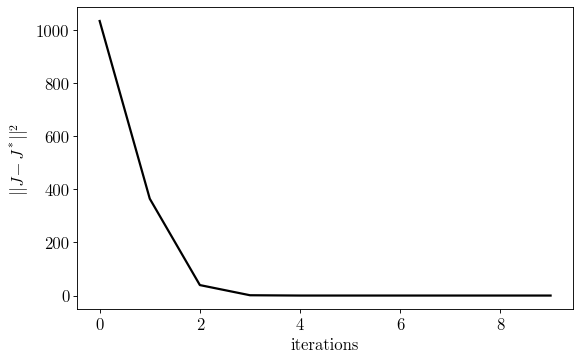

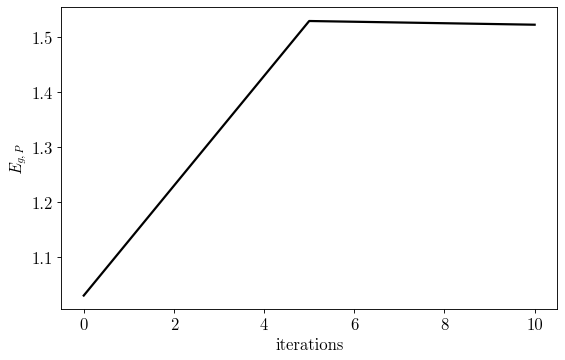

In [55]:
plt.plot(rss, color="black")
plt.xlabel("iterations")
plt.ylabel("$||J - J^*||^2$")
plt.show()
plt.plot(xs, color="black")
plt.xlabel("iterations")
plt.ylabel("$E_{g, P}$")
plt.show()